In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, cross_val_score

from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

In [2]:
df = pd.read_csv('Data_pre.csv')

In [3]:
df.dropna(inplace=True)

In [4]:
df.head()

,Unnamed: 0,comment,comment_pre,target
0,0,chưa ktra nên chưa biết đc đứa nào cũng đc như...,kiểm,2
1,1,Lời đầu tiên cho phép được xin vì sự sơ suất c...,cho_phép sơ_suất hát rõ_ràng,2
2,2,1m6 50kg size M khá vừa vặn nhưng hok có cơ nê...,vừa_vặn đỏ đỏ cổ đẹp nhức đẹp ổn,2
3,3,"Lần đầu mua shop, vải cũg khá ok. hợp vs mùa h...",đầu_shop hợp,2
4,4,"áo đẹp form đẹp, mọi thứ đều ok, giao hàng nha...",đẹp form đẹp hàng thích,2


In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['comment_pre'], df['target'], test_size=0.2, random_state=42)

In [6]:
# Convert the input data to str values
X_train = X_train.astype(str)
X_test = X_test.astype(str)
# Convert output data to str
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

In [7]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

In [8]:
# Convert the text data to sequences of numerical vectors
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [9]:
# Pad the sequences to the same length
max_length = max([len(seq) for seq in X_train_seq])
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

In [10]:
# Define the RNN model
model = Sequential([    
    Dense(1000, activation='relu', input_shape=(X_train_padded.shape[1],)),
    Dropout(0.3),
    Dense(500, activation='relu'),
    Dropout(0.3),
    Dense(300, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax'),
])

In [11]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [13]:
# Train the model with early stopping
history = model.fit(X_train_padded, y_train_cat, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10
4454/4454 [==============================] - 55s 12ms/step - loss: 0.7488 - accuracy: 0.8441 - val_loss: 0.4435 - val_accuracy: 0.8505
Epoch 2/10
4454/4454 [==============================] - 52s 12ms/step - loss: 0.4388 - accuracy: 0.8647 - val_loss: 0.4186 - val_accuracy: 0.8740
Epoch 3/10
4454/4454 [==============================] - 51s 12ms/step - loss: 0.4287 - accuracy: 0.8706 - val_loss: 0.4184 - val_accuracy: 0.8730
Epoch 4/10
4454/4454 [==============================] - 51s 12ms/step - loss: 0.4275 - accuracy: 0.8726 - val_loss: 0.4103 - val_accuracy: 0.8756
Epoch 5/10
4454/4454 [==============================] - 52s 12ms/step - loss: 0.4309 - accuracy: 0.8736 - val_loss: 0.4155 - val_accuracy: 0.8759
Epoch 6/10
4454/4454 [==============================] - 53s 12ms/step - loss: 0.4346 - accuracy: 0.8740 - val_loss: 0.4111 - val_accuracy: 0.8773
Epoch 7/10
4454/4454 [==============================] - 52s 12ms/step - loss: 0.4280 - accuracy: 0.8745 - val_loss: 0.4079 -

In [14]:
# Make predictions on the test data
y_pred = model.predict(X_test_padded)

In [15]:
# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

In [16]:
# Convert the one-hot encoded test labels to class labels
y_test_labels = np.argmax(y_test_cat, axis=1)

In [17]:
# Create a dataframe with the original comments, true labels, and predicted labels
results_df = pd.DataFrame({'comment_pre': X_test, 'target_true': y_test_labels, 'target_pred': y_pred_labels})

In [18]:
# Map the target labels back to their original names
results_df['target_true'] = results_df['target_true'].map({0: 'negative', 1: 'neutral', 2: 'positive'})
results_df['target_pred'] = results_df['target_pred'].map({0: 'negative', 1: 'neutral', 2: 'positive'})

In [19]:
results_df.head()

,comment_pre,target_true,target_pred
391159,dính đẹp,positive,positive
423320,thích thích mềm,positive,positive
416869,giới_thiệu thích đông đẹp đông dự ấm ủng_hộ,positive,positive
231022,đẹp,positive,positive
299161,dãn tốt rẻ,positive,positive


In [21]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Print the confusion matrix
print(cm)

[[ 1297    23  6405]
 [   16  1359  4385]
 [   52   240 75294]]


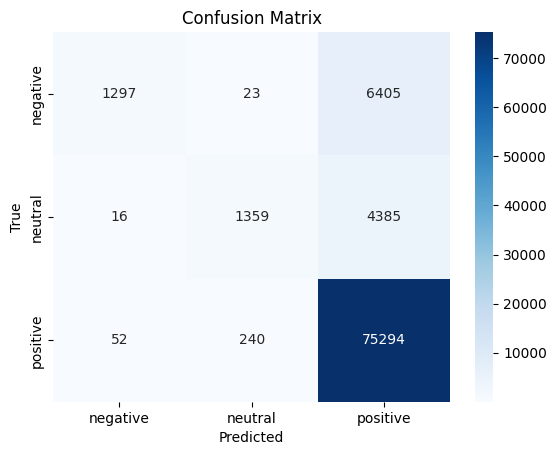

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])

# Set the axis labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [23]:
from sklearn.metrics import classification_report

print(classification_report(results_df['target_true'], results_df['target_pred']))

              precision    recall  f1-score   support

    negative       0.95      0.17      0.29      7725
     neutral       0.84      0.24      0.37      5760
    positive       0.87      1.00      0.93     75586

    accuracy                           0.88     89071
   macro avg       0.89      0.47      0.53     89071
weighted avg       0.88      0.88      0.84     89071



- Accuracy is 88% but recall, f1-score are low, choose Decision Tree from LDS6